
*Перед началом работы — установка и импорт необходимых библиотек:*

In [1]:
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
pip install (-U scikit-learn, catboost, spacy, -U pip setuptools wheel, torch torchvision torchaudio, transformers) -q

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `/opt/conda/bin/python -m pip install (-U scikit-learn, catboost, spacy, -U pip setuptools wheel, torch torchvision torchaudio, transformers) -q'
Note: you may need to restart the kernel to use updated packages.


______

**Импорт библиотек**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import re

from tqdm import tqdm
from statsmodels.graphics import tsaplots
from scipy import stats
from IPython.display import display

# Для работы с текстом:
import pymystem3
import spacy
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
from tqdm import notebook

# Модули для работы с моделями:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# CatBoost и LGBM
import catboost
from catboost import CatBoostClassifier, Pool, cv

# Метрики
from sklearn.metrics import f1_score, recall_score, precision_score

# BERT
import torch 
import transformers
from transformers import BertTokenizer

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Константы**

In [4]:
RANDOM_STATE = 42

## Подготовка

### Загрузка данных

In [5]:
data = pd.read_csv('C:\\toxic_comments.csv')

In [6]:
display(data.head())
data.info()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


____
**О Датасете:**

159292 строки

3 столбца:
- `Unnamed: 0`, `text` (входные признаки)
- `toxic`(целевой признак)

Столбец `text` с комментариями - тип object, остальные - int.

Пропусков в данных не наблюдаем.

Следует изучить столбец `Unnamed: 0`.
______

### Удаление признака

Проверим, что содержит в себе признак `Unnamed: 0`.

In [7]:
data['Unnamed: 0'].sort_values()

0              0
1              1
2              2
3              3
4              4
           ...  
159287    159446
159288    159447
159289    159448
159290    159449
159291    159450
Name: Unnamed: 0, Length: 159292, dtype: int64

Просто числовые значения, почти соответствующие индексу. Возможно, в процессе обработки были удалены некоторые строки: индекс обновили, а старый оставили в виде отдельного столбца.

Проверим, соответствует ли количество уникальных значений признака длине датасета:

In [8]:
print ('\nРазница между длиной датасета и количеством уникальных значений в столбце: \n', len(data) - data['Unnamed: 0'].nunique())


Разница между длиной датасета и количеством уникальных значений в столбце: 
 0


* соответствует

Удалим этот признак за ненадобностью:

In [9]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Избавились от лишнего признака.

### Проверка на дубликаты и пропуски

Пропуски:

In [10]:
data.isna().sum()

text     0
toxic    0
dtype: int64

* пропусков нет

Проверим на наличие дубликатов:

In [11]:
data.duplicated().sum()

0

* Дубликатов нет. 

Посмотрим количество уникальных значений признака `text`:

In [12]:
print ('Уникальных значений в text:\n', data['text'].nunique())
print ('\nРазница между длиной датасета и количеством уникальных значений: \n', len(data)-data['text'].nunique())

Уникальных значений в text:
 159292

Разница между длиной датасета и количеством уникальных значений: 
 0


Убедились, что повторяющихся строк нет, а каждый комментарий - уникальный.

### Изучение признаков

**toxic**

Уникальные значения:

In [13]:
data['toxic'].unique()

array([0, 1])

* все верно

Соотношение классов:

Количества каждого класса:
 0    143106
1     16186
Name: toxic, dtype: int64

В процентах:
 0    0.898
1    0.102
Name: toxic, dtype: float64


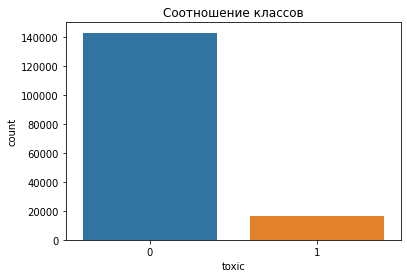

In [14]:
print ('Количества каждого класса:\n', data['toxic'].value_counts())
print ('\nВ процентах:\n', data['toxic'].value_counts(normalize=True).round(3))

sns.countplot(data = data, x='toxic')
plt.title('Соотношение классов')
plt.show()

* Соотношение 1 к 9
* Существенно преобладает класс 0 (не токсичные комментарии), 90% датасета
* Токсичных комментариев - всего 10 процентов.

Перед подготовкой признаков сохраним случайную выборку из 1000 строк из текущего датасета, чтобы использовать в дальнейшем неподготовленные данные с BERT:

In [15]:
data_bert = data.sample(500, random_state=RANDOM_STATE).reset_index(drop=True)

### Удаление лишних символов

Пишем функцию для удаления лишних символов. В некоторых строках видели в конце символ переноса "\n" - его также удалим:

In [16]:
def clear_text(text):
    # Приведем все буквы к нижнему регистру
    text = text.lower()
    text = re.sub(r"[^a-zA-Z']", " ", text)
    text = text.split()
    text = ' '.join(text)
    return text

Применяем функцию и проверяем результат:

In [17]:
data['text'] = data['text'].apply(clear_text)
data['text'].head()

0    explanation why the edits made under my userna...
1    d'aww he matches this background colour i'm se...
2    hey man i'm really not trying to edit war it's...
3    more i can't make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object

- Успешно

### Лемматизация

Напишем функцию для лемматизации:

In [19]:
nlp = spacy.load('en_core_web_sm')
def lemmatize(texts):
    lemm_texts = []
    for doc in tqdm(nlp.pipe(texts.values, disable = ['ner', 'parser']), total=texts.shape[0]):
        lemm_text = " ".join([i.lemma_ for i in doc])    
        lemm_texts.append(lemm_text) 
        
    return lemm_texts

Применяем к данным:

In [21]:
data['lemmed_text'] = lemmatize(data['text'])
data['lemmed_text']

100%|██████████| 159292/159292 [09:57<00:00, 266.44it/s]


0         explanation why the edit make under my usernam...
1         d'aww he match this background colour I be see...
2         hey man I be really not try to edit war it be ...
3         more I can not make any real suggestion on imp...
4         you sir be my hero any chance you remember wha...
                                ...                        
159287    and for the second time of ask when your view ...
159288    you should be ashamed of yourself that be a ho...
159289    spitzer umm there s no actual article for pros...
159290    and it look like it be actually you who put on...
159291    and I really do not think you understand I com...
Name: lemmed_text, Length: 159292, dtype: object

- Получили столбец с лемматизированным текстом.

________
### Вывод

Данные загружены:
- изначально 3 столбца: индекс, текст (входящий признак), токсичность (таргет). 159292 строки.
- Удален лишний признак (Просто числовые значения, почти соответствующие индексу. Возможно, в процессе обработки были удалены некоторые строки: индекс обновили, а старый оставили в виде отдельного столбца.)
- Дубликатов и пропусков не обнаружено. Все тексты, представленные в датасете, уникальны и не повторяются.

Подготовка данных:
- Удалены лишние символы, знаки переноса "\n", все буквы приведены к нижнему регистру
- Проведена лемматизация текстов.
__________

## Обучение моделей

### Разбиение на выборки

Разбиваем на входные данные (подготовленный лемматизированный текст) и таргет (токсичный комментарий - 0\1). Train и test в соотношении 9 к 1:

In [23]:
X = data['lemmed_text']
y = data['toxic']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=RANDOM_STATE)

In [25]:
print ('Размеры тренировочных X и y:\n', X_train.shape, y_train.shape)
print ('Размеры тестовых X и y:\n', X_test.shape, y_test.shape)

Размеры тренировочных X и y:
 (143362,) (143362,)
Размеры тестовых X и y:
 (15930,) (15930,)


Проверим соотношения классов тренировочной и тестовой выборок (если разница между долями присутствия классов в выборках равна нулю, значит, они распределены равномерно):

In [26]:
y_train.value_counts(normalize=True) - y_test.value_counts(normalize=True)

0    0.000022
1   -0.000022
Name: toxic, dtype: float64

- Классы представлены в одинаковых пропорциях

### TF-IDF

Считаем TF-IDF для обеих выборок:

In [28]:
# считаем величину TF-IDF для обучающей выборки
count_tf_idf_train = TfidfVectorizer(max_features=50000)
tf_idf_train = count_tf_idf_train.fit_transform(X_train)
display(tf_idf_train.shape)

(143362, 50000)

In [29]:
# считаем величину TF-IDF для тестовой выборки
tf_idf_test = count_tf_idf_train.transform(X_test)
display(tf_idf_test.shape)

(15930, 50000)

### LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, SVC

Переберем следующие гиперпараметры для 4 моделей:

In [30]:
pipe = Pipeline([('models', LogisticRegression())])

param_grid = [

    # KNeighborsClassifier()
    {'models': [KNeighborsClassifier()], 
     'models__n_neighbors': range(5, 10)
    },

    # LogisticRegression()
    {'models': [LogisticRegression(random_state=RANDOM_STATE, 
                                   solver='liblinear', 
                                   penalty='l2')], 
     'models__C': range(1, 50)  
    }, 
    
    # SVC() - с линейным и нелинейным ядром
    {'models': [SVC(random_state=RANDOM_STATE)], 
     'models__kernel': ['rbf', 'linear']
    }
]

Запускаем перебор через RandomizedSearchCV:

In [31]:
grid_search = RandomizedSearchCV(
    pipe, 
    param_grid, 
    cv=3,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
grid_search.fit(tf_idf_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to Tr

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('models', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(5, 10)},
                                        {'models': [LogisticRegression(C=9,
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 50)},
                                        {'models': [SVC(random_state=42)],
                                         'models__kernel': ['rbf', 'linear']}],
                   random_state=42, scoring='f1')

Пять лучших моделей:

In [32]:
print ('\n3 лучшие модели и их значения метрики:')

display (pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')[
['rank_test_score', 'param_models', 'param_models__C', 'mean_fit_time', 'mean_test_score']].head(3))


3 лучшие модели и их значения метрики:


,rank_test_score,param_models,param_models__C,mean_fit_time,mean_test_score
3,1,"LogisticRegression(C=9, random_state=42, solve...",9,17.378093,0.781533
9,2,"LogisticRegression(C=9, random_state=42, solve...",8,17.316582,0.781378
4,3,"LogisticRegression(C=9, random_state=42, solve...",15,20.250218,0.780855


In [33]:
print ('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('\nМетрика лучшей модели на кросс-валидационной выборке:', round(grid_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 LogisticRegression(C=9, random_state=42, solver='liblinear'))])

Метрика лучшей модели на кросс-валидационной выборке: 0.78


**Результат:**

- Лучшей оказалась модель LogisticRegression с регуляризацией l2 и силой регуляризации C=9.
- Метрика лучшей модели на кросс-валидационной выборке: 0.78.

Сохраним значение метрики лучшей модели на кросс-валидации:

In [34]:
lr_f1 = round(grid_search.best_score_, 3)
lr_f1

0.782

### CatBoostClassifier

Посмотрим, какой результат кросс-валидации получим градиентным бустингом при помощи CatBoostClassifier'а. Возьмем количество итераций 150 и шаг learning_rate 0.4:

In [35]:
params = {
    'loss_function': 'Logloss',
    'iterations': 100,
    'eval_metric': 'F1',
    'learning_rate': 0.4
}

cv_data = cv(
    params=params,
    pool=Pool(tf_idf_train, y_train),
    fold_count=3, 
    shuffle=True, 
    partition_random_seed=0,
    stratified=True, 
    verbose=False
)

Training on fold [0/3]

bestTest = 0.7510906447
bestIteration = 95

Training on fold [1/3]

bestTest = 0.7411019015
bestIteration = 99



**Результат:**

- Получили f1, равным 0.75, 0.75 и 0.74, что ниже, чем у логистической регрессии: 0.78 - среднее значение f1 на кросс-валидации.

### Выбор модели

С учетом удовлетворительного и наивысшего, в сравнении с другими моделями, результата f1 кросс-валидации, а также сравнительно быстрой скорости обучения, в дальнейшем на тестовых данных будем использовать модель:
- **LogisticRegression с регуляризацией l2 и силой регуляризации C=9**

____________
### Вывод

- Данные разбиты на обучающую и тестовую выборки в соотношении 9 к 1.
- Получены корпусы для train и test и посчитаны величины TF-IDF для них (входящие признаки).
- Перебраны гиперпараметры для LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, SVC.
- Обучена модель CatBoostClassifier с количеством итераций 150 и шагом learning_rate 0.4.

Результат метрики f1 на кросс-валидации оказался лучшим у следующей модели:

- LogisticRegression с регуляризацией l2 и силой регуляризации C=9

_________

## Проверка на тестовых данных

Предсказываем значения X_test:

In [36]:
preds = grid_search.best_estimator_.predict(tf_idf_test)
print ('Предсказанные значения:', preds)

Предсказанные значения: [0 0 1 ... 0 0 0]


**Результат метрики f1:**

In [37]:
print('Результат метрики на тестовых данных:\n f1 =', round(f1_score(y_test, preds), 3))

Результат метрики на тестовых данных:
 f1 = 0.799


- Получили хорошее значение 0.8, выше минимально необходимого 0.75.

**Precision и Recall**

Посмотрим, как модель определяет разные классы:

In [38]:
print('Precision:\n ', round(precision_score(y_test, preds), 3))
print('\nRecall:\n ', round(recall_score(y_test, preds), 3))

Precision:
  0.897

Recall:
  0.721


- в 89,7% случаев комментарий, помеченный моделью как токсичный, был действительно токсичным
- при этом модель нашла только 72% токсичных комментариев в тестовой выборке

______
### Вывод

Результаты на тестовой выборке:

- f1 = 0.8

Precision: 0.88
 
Recall 0.72

В 89.7% случаев комментарий, помеченный моделью как токсичный, был действительно токсичным. При этом модель нашла только 72% токсичных комментариев в тестовой выборке.
_________

## Дополнительно: знакомство с BERT

*В данном разделе работать будем с уменьшенной выборкой из 1000 строк - исследуем, как работает модель BERT. Ресурсов для обработки большого массива данных у нас нет.*

Инициализируем токенизатор как объект класса BertTokenizer(), инициализируем саму модель класса BertModel - передадим ей файл с предобученной моделью и конфигурацией:

In [39]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased') 
model = transformers.BertModel.from_pretrained('bert-base-uncased', config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Преобразуем текст в номера токенов из словаря методом encode:

In [41]:
tokenized = data_bert['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

Находим максимальную длину вектора и применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными:

In [42]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [43]:
padded.shape

(500, 512)

In [44]:
# Определяем устройство (GPU, если доступен, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Размер батча
batch_size = 16

# Сделаем пустой список для хранения эмбеддингов текстов
embeddings = []

# Переносим модель на GPU
model.to(device)

# Проходим по данным батчами
for i in notebook.tqdm(range(padded.shape[0] // batch_size + 1)):
    # Преобразуем данные и переносим на GPU
    batch = torch.LongTensor(padded[batch_size * i:batch_size * (i + 1)]).to(device)
    
    # Преобразуем маску и переносим на GPU
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i:batch_size * (i + 1)]).to(device)
    
    # Отключаем вычисление градиентов для ускорения
    with torch.no_grad():
        # Передаем модели данные и маску
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
    # Переносим результат обратно на CPU и сохраняем в список
    embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())

  0%|          | 0/32 [00:00<?, ?it/s]

**Обучим и протестируем модель, которая ранее показывала наилучший результат:**

In [46]:
features = np.concatenate(embeddings)

X = features
y = data_bert['toxic']
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.25, random_state=RANDOM_STATE)

model = LogisticRegression(C=9, random_state=RANDOM_STATE, solver='liblinear', penalty='l2')

model.fit(X_train, y_train)
predictions = model.predict(X_test)

print ('f1 = ', round(f1_score(y_test, predictions), 2))
print ('Precision:', round(precision_score(y_test, predictions), 2))
print ('Recall:', round(recall_score(y_test, predictions), 2))

f1 =  0.61
Precision: 0.78
Recall: 0.5


- Видим, что значение метрики f1 довольно низкое.
- 78% текстов, помеченных как токсичные, на самом деле являются такими.
- Модель нашла меньше половины токсичных текстов.

Если увеличить силу регуляризации до 30, получим следующее:

In [47]:
model = LogisticRegression(C=30, random_state=RANDOM_STATE, solver='liblinear', penalty='l2')

model.fit(X_train, y_train)
predictions = model.predict(X_test)

print ('f1 = ', round(f1_score(y_test, predictions), 2))
print ('Precision:', round(precision_score(y_test, predictions), 2))
print ('Recall:', round(recall_score(y_test, predictions), 2))

f1 =  0.61
Precision: 0.78
Recall: 0.5


- Метрика f1 выросла до 0.6
- Процент найденных токсичных комментариев моделью поднялся выше 50%
- Процент верно классифицированных токсичных комментариев также поднялся

**Вывод:**

На самом деле, неплохой результат с учетом того, что используем выборку всего из 1000 объектов. При грамотном подборе модели и гиперпараметров, вероятно, метрики можно улучшить еще сильнее.

Тем не менее, значения метрики будут сильно зависеть от тестовой выборки. Для решения классификации тональности текста точно нужен намного больший датасет для обучения.

## Вывод

_______
Обучена модель, классифицирующая тональность текста (позитивный или негативный):

Модель:
- LogisticRegression с регуляризацией l2 и силой регуляризации C=9

Метрика f1 на тестовой выборке:
- f1 = 0.8
_____________



**Этапы:**

__ Загрузка данных: __
- изначально 3 столбца: индекс, текст (входящий признак), токсичность (таргет). 159292 строки.

__ Подготовка: __
- Удален лишний признак (Просто числовые значения, почти соответствующие индексу. Возможно, в процессе обработки были удалены некоторые строки: индекс обновили, а старый оставили в виде отдельного столбца.)
- Дубликатов и пропусков не обнаружено. Все тексты, представленные в датасете, уникальны и не повторяются.
- Удалены лишние символы, знаки переноса "\n", все буквы приведены к нижнему регистру
- Проведена лемматизация текстов.

__ Обучение моделей: __
- Данные разбиты на обучающую и тестовую выборки в соотношении 3 к 1.
- Получены корпусы для train и test и посчитаны величины TF-IDF для них (входящие признаки).
- Перебраны гиперпараметры для LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, SVC.
- Обучена модель CatBoostClassifier с количеством итераций 150 и шагом learning_rate 0.4.
- Результат метрики f1 на кросс-валидации оказался лучшим у следующей модели:
    - LogisticRegression с регуляризацией l2 и силой регуляризации C=9

__ Проверка на тестовых данных: __
- f1 = 0.8
- Precision: 0.89
- Recall 0.72

В 89.5% случаев комментарий, помеченный моделью как токсичный, был действительно токсичным. При этом модель нашла только 72% токсичных комментариев в тестовой выборке.

___
Дополнительно - BERT

На уменьшенной до 1000 строк выборке достигли следующих результатов:
- Метрика f1 = 0.6
- Recall - 52%
- Precision - 71%

Неплохой результат с учетом того, что используем выборку всего из 1000 объектов. При грамотном подборе модели и гиперпараметров, вероятно, метрики можно улучшить еще сильнее.

Тем не менее, значения метрики будут сильно зависеть от тестовой выборки. Для решения классификации тональности текста точно нужен намного больший датасет для обучения.